<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [1]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [3]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Userai: cuda


Collegamento al drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [5]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [6]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [7]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

decido di non rimuovere il silenzio

In [8]:
def load_audio_file(file_path, sr=44100, duration=5.0):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    y = librosa.util.normalize(y)           # normalizzazione RMS
    if len(y) < int(sr * duration):
        padding = int(sr * duration) - len(y)
        y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

In [9]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [03:26<00:00, 20.61s/it]


In [10]:
X_audio = np.array(X_audio)
y_labels = np.array(y_labels)

print("Shape X:", X_audio.shape)
print("Shape y:", y_labels.shape)

Shape X: (400, 220500)
Shape y: (400,)


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

tolgo il silenzio? su esc10 si su esc50 no ?
metto noise injection?
noise = np.random.normal(0, 0.005, y.shape)
  y_noisy = y + noise
  augmented.append(y_noisy)

In [12]:
def naa(y, sr):
  augmented = []
  augmented.append(y)
  #PPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2))
  #NPS
  augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
  #Slow Time Stretching
  augmented.append(librosa.effects.time_stretch(y, rate=0.7))
  #Fast Time Streatching
  augmented.append(librosa.effects.time_stretch(y, rate=1.2))
  return augmented

In [13]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [01:11<00:00,  3.89it/s]


## Converti in log-Mel

In [14]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


In [15]:
def batch_logmel(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel_list.append(mel)
    return mel_list


In [16]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:00<00:00, 142.96it/s]


In [17]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1400
Val set: 60
Test set: 60
Shape primo sample train: (64, 431)


visualizzo logmel spect

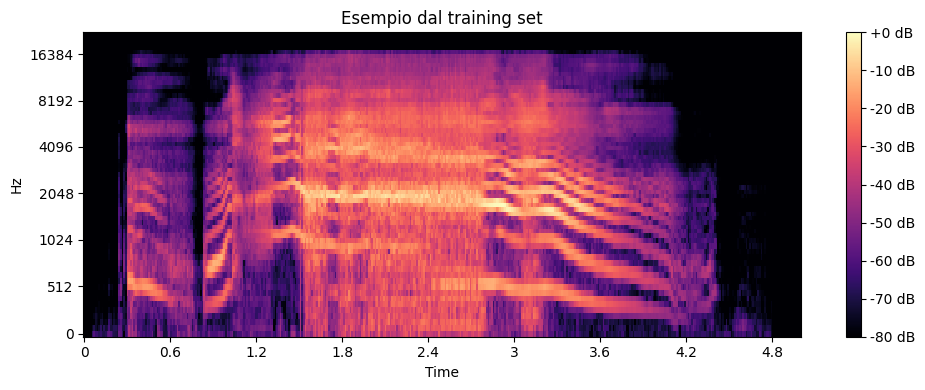

Class:  3


In [18]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
show_mel(X_train_mel[0], title="Esempio dal training set")
print("Class: ", y_train_aug[0])


In [19]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding

In [20]:
max_len = max([mel.shape[1] for mel in X_train_mel])
def pad_mel(mel, max_len):
    if mel.shape[1] < max_len:
        pad_width = max_len - mel.shape[1]
        return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    else:
        return mel[:, :max_len]
X_train_mel = [pad_mel(mel, max_len) for mel in X_train_mel]
X_val_mel = [pad_mel(mel, max_len) for mel in X_val_mel]
X_test_mel = [pad_mel(mel, max_len) for mel in X_test_mel]


## DATA AUG TAA

In [21]:
taa_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti

Normalizzazione

In [23]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

Converto in tensori

In [24]:
X_train = torch.from_numpy(X_train_mel_np).float()
y_train = torch.from_numpy(y_train_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
y_val = torch.from_numpy(np.array(y_val)).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_test = torch.from_numpy(np.array(y_test)).float()

In [25]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1400, 64, 616, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


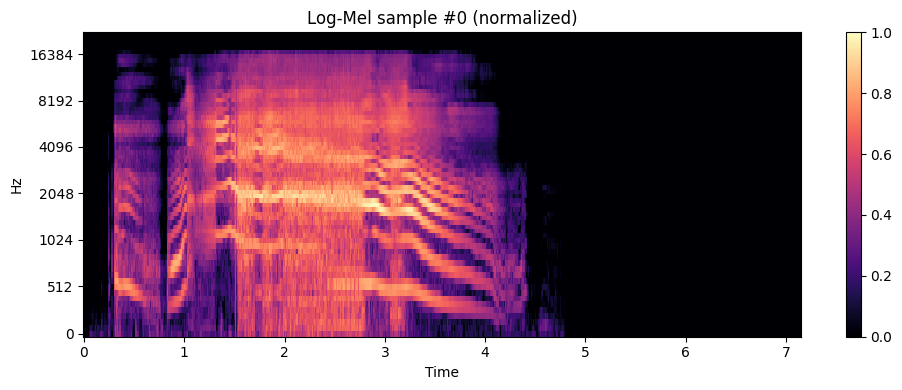

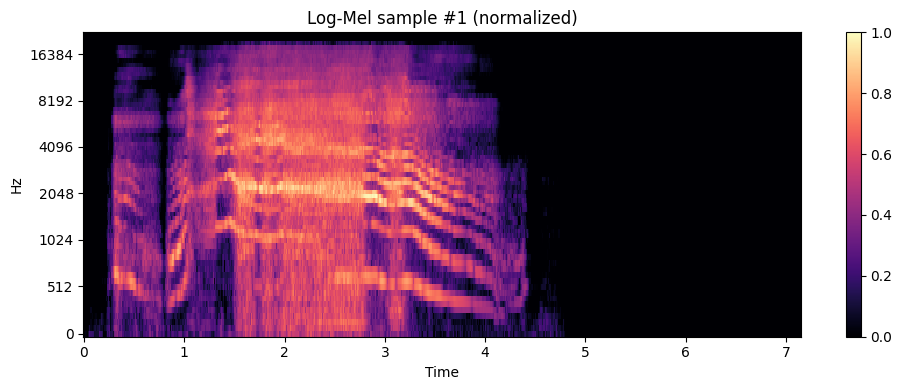

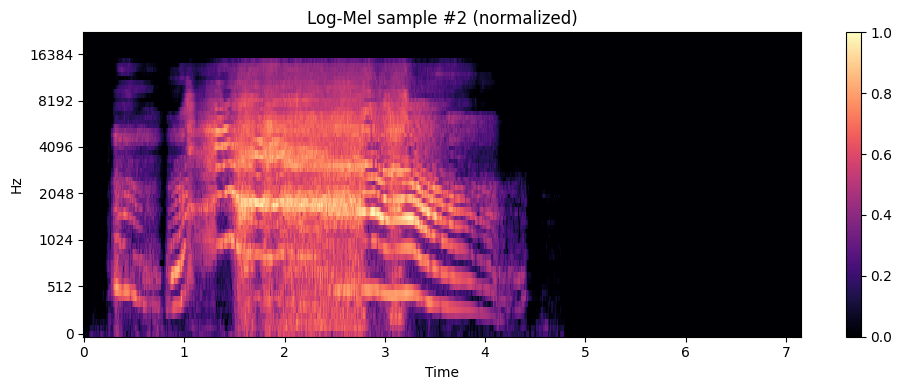

In [26]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()

for i in range(3):
    show_mel_sample(i)

In [27]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1400])
Etichette uniche: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Esempio 0: label = 3.0
Esempio 1: label = 3.0
Esempio 2: label = 3.0


# Spike Encoding


## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values.

By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated.
However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$

In [55]:
import torch
from torch.utils.data import Dataset
import snntorch.spikegen as spikegen

class DeltaAudioDataset(Dataset):
  def __init__(self, X, y, threshold=0.05, timesteps=10, off_spike=True):
    """
    X: Tensor of shape [num_samples, n_mels, time_steps, 1]
    y: Tensor of shape [num_samples]
    """
    self.X = X
    self.y = y
    self.timesteps = timesteps
    self.threshold = threshold
    self.off_spike = off_spike

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1) # [n_mels, time_steps]
    y = self.y[idx]

    chunk_len = x.shape[-1] // self.timesteps
    chunks = []
    for t in range(self.timesteps):
      window = x[:, t * chunk_len: (t + 1) * chunk_len]
      chunk = window.mean(dim=-1)
      chunks.append(chunk)

    x_chunks = torch.stack(chunks, dim=0)

    # Apply delta modulation (shape stays [time_steps, n_mels])
    spike_train = spikegen.delta(
        x_chunks,
        threshold=self.threshold,
        off_spike=self.off_spike
    )

    return spike_train, y.long()

train_dataset = DeltaAudioDataset(
    X_train,
    y_train,
    threshold=0.1,
    timesteps=10
)
val_dataset = DeltaAudioDataset(
    X_val,
    y_val,
    threshold=0.1,
    timesteps=10
)
test_dataset = DeltaAudioDataset(
    X_test,
    y_test,
    threshold=0.1,
    timesteps=10
)

In [56]:
delta_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)

X_batch, y_batch = next(iter(delta_train_dataloader))
print(X_batch.shape)

torch.Size([32, 10, 64])


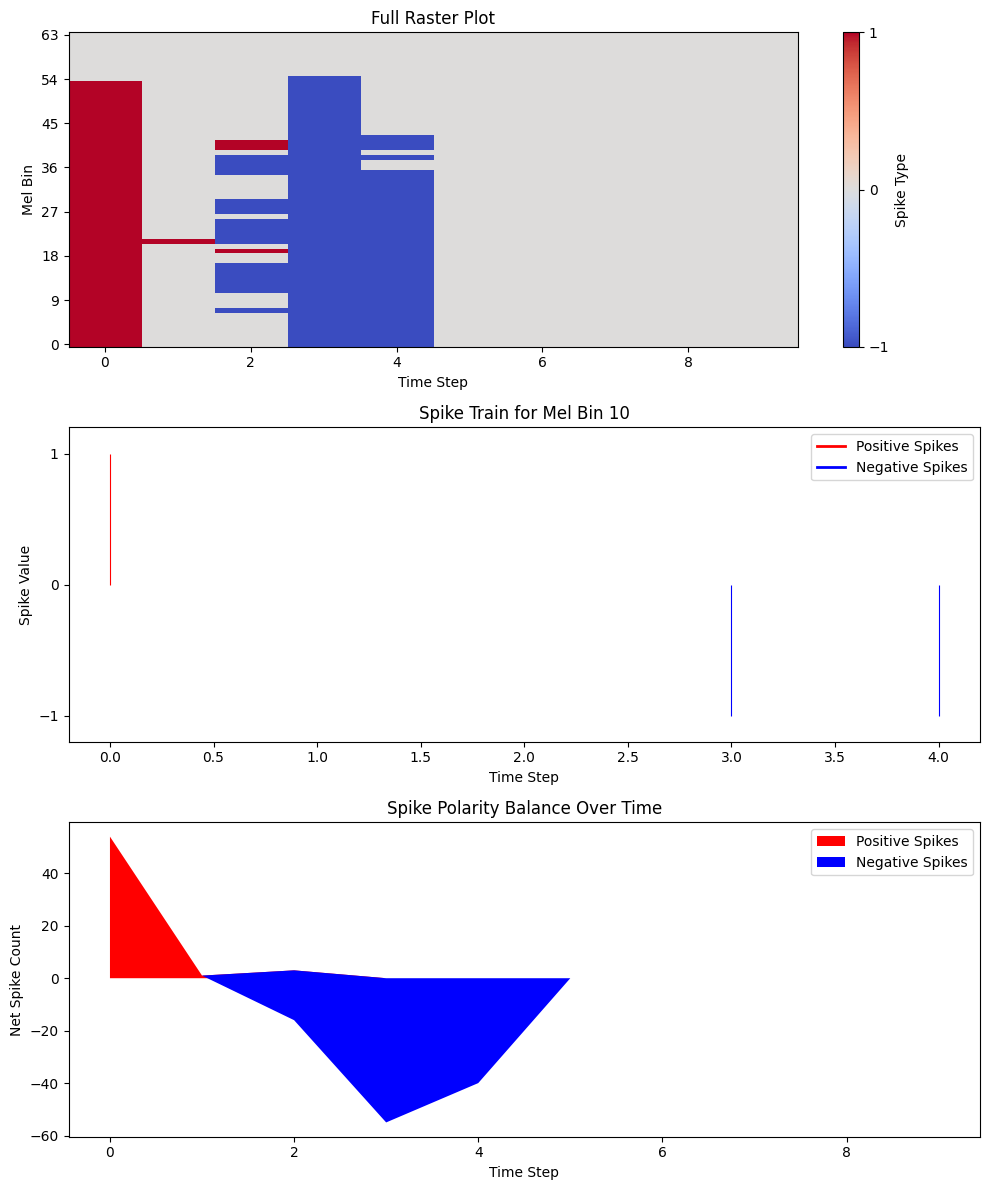

Class rooster


In [57]:
def visualize_delta_spikes(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()


sample_idx = 0
visualize_delta_spikes(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(y_batch[sample_idx].item()).name)

## Threshold Adaptive Encoding

Unlike **rate encoding**, where the value directly determines spike probability, Threshold Adaptive Encoding works by:

Setting a dynamic threshold for each input feature
Generating spikes when the input signal crosses this threshold
Adapting the threshold after each spike according to the local signal properties

This encoding method is biologically inspired, as it better mimics how neurons in the brain respond to varying stimulus intensities.


In [31]:
class ThresholdAdaptiveEncoding:
    def __init__(self, threshold=0.1, alpha=1.05):
        """
        Initialize the Threshold-Adaptive Encoding method.

        Args:
            threshold (float): Initial threshold value
            alpha (float): Threshold adaptation factor
                           > 1 for increase after spike
                           < 1 for decrease when no spike
        """
        self.threshold = threshold
        self.alpha = alpha

    def encode_single_channel(self, input_signal):
        """
        Apply Threshold-Adaptive Encoding to a single channel.

        Args:
            input_signal: 1D tensor of signal values

        Returns:
            spikes: 1D tensor with values {-1, 0, 1}
        """
        L = len(input_signal)
        spikes = torch.zeros_like(input_signal)

        # Initialize base to first input value
        base = input_signal[0].item()
        # Initialize threshold
        threshold = self.threshold

        # Implement the TAE algorithm
        for i in range(1, L):
            if input_signal[i] >= base + threshold:
                # Generate positive spike
                spikes[i] = 1
                # Update base
                base = base + threshold
                # Increase threshold
                threshold = threshold * self.alpha
            elif input_signal[i] <= base - threshold:
                # Generate negative spike
                spikes[i] = -1
                # Update base
                base = base - threshold
                # Increase threshold
                threshold = threshold * self.alpha
            else:
                # No spike, decrease threshold
                threshold = threshold / self.alpha

        return spikes

    def __call__(self, data):
        """
        Apply Threshold-Adaptive Encoding to a batch of data.

        Args:
            data: list of tuples (input_tensor, label)
                 input_tensor shape: [n_mels, time_frames, 1] or [n_mels, time_frames]

        Returns:
            List containing:
                - spike_trains: tensor of shape [batch_size, time_frames, n_mels, 1]
                - labels: tensor of shape [batch_size]
        """
        data_spikes = []

        for sample in data:
            audio_tensor = sample[0].clone().detach().float()  # Shape: [n_mels, time_frames, 1] or [n_mels, time_frames]

            # Check if we need to squeeze the channel dimension
            if len(audio_tensor.shape) == 3 and audio_tensor.shape[2] == 1:
                audio_tensor = audio_tensor.squeeze(2)  # Remove channel dim if it's size 1
                has_channel_dim = True
            else:
                has_channel_dim = len(audio_tensor.shape) == 3

            # Now audio_tensor shape is [n_mels, time_frames]
            n_mels, time_frames = audio_tensor.shape
            spikes = torch.zeros_like(audio_tensor)

            # Process each mel bin separately
            for mel in range(n_mels):
                # Apply TAE to each time series
                input_signal = audio_tensor[mel, :]
                spikes[mel, :] = self.encode_single_channel(input_signal)

            # Permute to match expected output shape [time_frames, n_mels]
            spikes = spikes.permute(1, 0)

            # Add channel dimension back if it existed in the input
            if has_channel_dim:
                spikes = spikes.unsqueeze(2)  # Shape: [time_frames, n_mels, 1]

            data_spikes.append(spikes)

        # Stack the results
        spike_trains = torch.stack([spike for spike in data_spikes])
        labels = torch.stack([sample[1] for sample in data])

        return [spike_trains, labels]

In [32]:
tae_encoding = ThresholdAdaptiveEncoding(threshold=0.3, alpha=1.05)
tae_train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=tae_encoding)

encoded_tae_spike_batch0 = next(iter(tae_train_dataloader))

print(encoded_tae_spike_batch0[0].shape)

torch.Size([32, 64, 10])


IndexError: index 27 is out of bounds for axis 1 with size 10

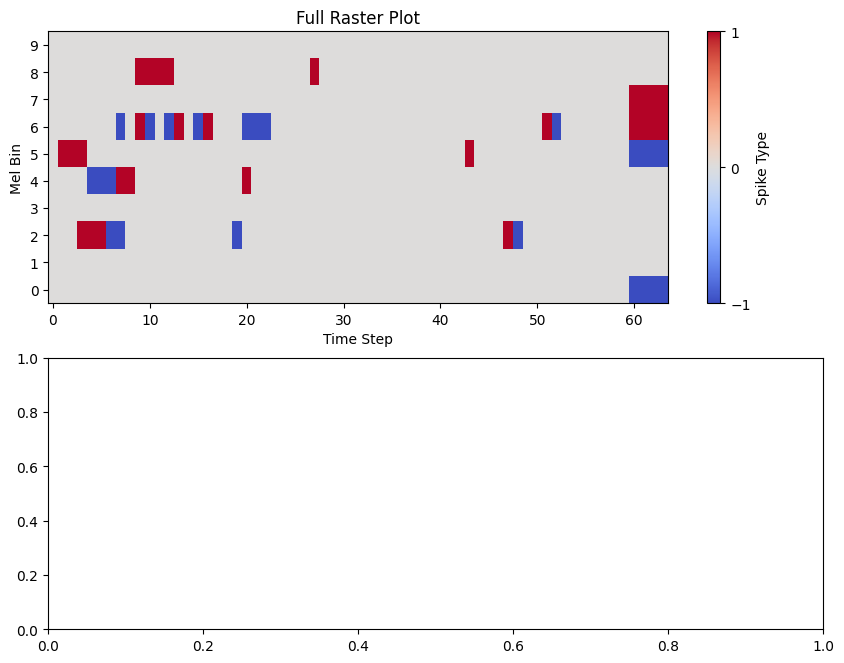

In [33]:
def visualize_tae_spikes(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels, channel]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0][sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels, channel]
        if len(spike_tensor.shape) == 4:
            spikes = spike_tensor[sample_idx, :, :, 0].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()


sample_idx = 19
visualize_tae_spikes(encoded_tae_spike_batch0, sample_idx=sample_idx, mel_bin=27)
print("Class", ESCLabels(encoded_tae_spike_batch0[1][sample_idx].item()).name)

## Moving Window

## Step Forward

# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [58]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=False,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to first hidden layer
        self.fc1 = torch.nn.Linear(n_mels, hidden_sizes[0])
        self.lif_in = snn.Leaky(
            beta=torch.rand(hidden_sizes[0]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: First hidden to second hidden layer
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif_hidden = snn.Leaky(
            beta=torch.rand(hidden_sizes[1]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_sizes[1], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.rand(num_classes),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

    def forward(self, x):
      # Input shape: [batch_size, time_steps, n_mels]
      batch_size = x.shape[0]
      time_steps = x.shape[1]

      mem_1 = self.lif_in.init_leaky()
      mem_2 = self.lif_hidden.init_leaky()
      mem_o = self.lif_out.init_leaky()

      spk_rec = []
      mem_rec = []

      for step in range(time_steps):
        # split the signal into self.timesteps windows
        x_t = x[:, step, :]  # Shape: [batch_size, n_mels]

        cur1 = self.fc1(x_t)
        spk1, mem_1 = self.lif_in(cur1, mem_1)

        cur2 = self.fc2(spk1)
        spk2, mem_2 = self.lif_hidden(cur2, mem_2)

        cur_out = self.fc_out(spk2)
        spk_out, mem_o = self.lif_out(cur_out, mem_o)

        spk_rec.append(spk_out)
        mem_rec.append(mem_o)

      return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [59]:
n_mels = 64
hidden_sizes = [128, 64]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=n_mels,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=False,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 8,320
├─Leaky: 1-2                             [32, 128]                 128
├─Linear: 1-3                            [32, 64]                  8,256
├─Leaky: 1-4                             [32, 64]                  64
├─Linear: 1-5                            [32, 10]                  650
├─Leaky: 1-6                             [32, 10]                  10
Total params: 17,428
Trainable params: 17,428
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.55
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.07
Estimated Total Size (MB): 0.18

In [68]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Optional batch limiting (for quick testing)
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [73]:
num_epochs = 50
patience = 10
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)


train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Train batches:   0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-68-6f479fe3a455>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches:  98%|█████████▊| 43/44 [00:03<00:00, 15.62it/s]
                                                              <ipython-input-68-6f479fe3a455>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   2%|▏         | 1/50 [00:03<03:06,  3.80s/it]

Epoch 1/50 - 3s - loss: 2.0866 - acc: 0.2370 - val_loss: 2.2006 - val_acc: 0.2366



Epochs:   4%|▍         | 2/50 [00:06<02:32,  3.18s/it]

Epoch 2/50 - 2s - loss: 1.9644 - acc: 0.2668 - val_loss: 2.0430 - val_acc: 0.2857



Epochs:   6%|▌         | 3/50 [00:09<02:19,  2.98s/it]

Epoch 3/50 - 2s - loss: 1.8821 - acc: 0.2973 - val_loss: 2.1020 - val_acc: 0.2478



Epochs:   8%|▊         | 4/50 [00:11<02:12,  2.87s/it]

Epoch 4/50 - 2s - loss: 1.7731 - acc: 0.3442 - val_loss: 2.0825 - val_acc: 0.2812



Epochs:  10%|█         | 5/50 [00:15<02:13,  2.97s/it]

Epoch 5/50 - 3s - loss: 1.7049 - acc: 0.3606 - val_loss: 1.8642 - val_acc: 0.4353



Epochs:  12%|█▏        | 6/50 [00:18<02:16,  3.10s/it]

Epoch 6/50 - 3s - loss: 1.6687 - acc: 0.3904 - val_loss: 1.9703 - val_acc: 0.3371



Epochs:  14%|█▍        | 7/50 [00:21<02:07,  2.97s/it]

Epoch 7/50 - 2s - loss: 1.6385 - acc: 0.3821 - val_loss: 1.9828 - val_acc: 0.3839



Epochs:  16%|█▌        | 8/50 [00:23<02:02,  2.91s/it]

Epoch 8/50 - 2s - loss: 1.6062 - acc: 0.4124 - val_loss: 1.7823 - val_acc: 0.4219



Epochs:  18%|█▊        | 9/50 [00:26<01:56,  2.85s/it]

Epoch 9/50 - 2s - loss: 1.5129 - acc: 0.4318 - val_loss: 1.7756 - val_acc: 0.3482



Epochs:  20%|██        | 10/50 [00:30<02:05,  3.13s/it]

Epoch 10/50 - 3s - loss: 1.4934 - acc: 0.4392 - val_loss: 1.9253 - val_acc: 0.3683



Epochs:  22%|██▏       | 11/50 [00:33<01:57,  3.00s/it]

Epoch 11/50 - 2s - loss: 1.4623 - acc: 0.4553 - val_loss: 1.8668 - val_acc: 0.3304



Epochs:  24%|██▍       | 12/50 [00:35<01:50,  2.90s/it]

Epoch 12/50 - 2s - loss: 1.4179 - acc: 0.4612 - val_loss: 1.8211 - val_acc: 0.3661



Epochs:  26%|██▌       | 13/50 [00:38<01:45,  2.84s/it]

Epoch 13/50 - 2s - loss: 1.3882 - acc: 0.4796 - val_loss: 1.9547 - val_acc: 0.3371



Epochs:  28%|██▊       | 14/50 [00:41<01:45,  2.93s/it]

Epoch 14/50 - 3s - loss: 1.3663 - acc: 0.4820 - val_loss: 1.8480 - val_acc: 0.3103



Epochs:  30%|███       | 15/50 [00:45<01:46,  3.05s/it]

Epoch 15/50 - 3s - loss: 1.3960 - acc: 0.4714 - val_loss: 2.0097 - val_acc: 0.3192



Epochs:  32%|███▏      | 16/50 [00:47<01:40,  2.94s/it]

Epoch 16/50 - 2s - loss: 1.3289 - acc: 0.5028 - val_loss: 1.8657 - val_acc: 0.3616



Epochs:  34%|███▍      | 17/50 [00:50<01:35,  2.89s/it]

Epoch 17/50 - 2s - loss: 1.3861 - acc: 0.4931 - val_loss: 2.0965 - val_acc: 0.4442



Epochs:  36%|███▌      | 18/50 [00:53<01:31,  2.86s/it]

Epoch 18/50 - 2s - loss: 1.3581 - acc: 0.5038 - val_loss: 1.9990 - val_acc: 0.3638



Epochs:  38%|███▊      | 19/50 [00:56<01:36,  3.11s/it]

Epoch 19/50 - 3s - loss: 1.3346 - acc: 0.4979 - val_loss: 1.7404 - val_acc: 0.4174



Epochs:  40%|████      | 20/50 [01:00<01:37,  3.25s/it]

Epoch 20/50 - 3s - loss: 1.3103 - acc: 0.5144 - val_loss: 2.0497 - val_acc: 0.3147



Epochs:  42%|████▏     | 21/50 [01:03<01:29,  3.10s/it]

Epoch 21/50 - 2s - loss: 1.3116 - acc: 0.5038 - val_loss: 1.7288 - val_acc: 0.4353



Epochs:  44%|████▍     | 22/50 [01:06<01:23,  3.00s/it]

Epoch 22/50 - 2s - loss: 1.2910 - acc: 0.4998 - val_loss: 1.8427 - val_acc: 0.4152



Epochs:  46%|████▌     | 23/50 [01:09<01:25,  3.17s/it]

Epoch 23/50 - 3s - loss: 1.2535 - acc: 0.5289 - val_loss: 1.7416 - val_acc: 0.3638



Epochs:  48%|████▊     | 24/50 [01:12<01:20,  3.10s/it]

Epoch 24/50 - 2s - loss: 1.2386 - acc: 0.5466 - val_loss: 1.7624 - val_acc: 0.4219



Epochs:  50%|█████     | 25/50 [01:15<01:15,  3.01s/it]

Epoch 25/50 - 2s - loss: 1.1921 - acc: 0.5450 - val_loss: 1.7991 - val_acc: 0.4330



Epochs:  52%|█████▏    | 26/50 [01:18<01:10,  2.93s/it]

Epoch 26/50 - 2s - loss: 1.2349 - acc: 0.5249 - val_loss: 1.7684 - val_acc: 0.3638



Epochs:  54%|█████▍    | 27/50 [01:21<01:08,  3.00s/it]

Epoch 27/50 - 3s - loss: 1.1786 - acc: 0.5585 - val_loss: 1.6697 - val_acc: 0.3839



Epochs:  56%|█████▌    | 28/50 [01:24<01:09,  3.17s/it]

Epoch 28/50 - 3s - loss: 1.1910 - acc: 0.5497 - val_loss: 1.5965 - val_acc: 0.4688



Epochs:  58%|█████▊    | 29/50 [01:27<01:04,  3.06s/it]

Epoch 29/50 - 2s - loss: 1.1733 - acc: 0.5618 - val_loss: 1.6852 - val_acc: 0.3661



Epochs:  60%|██████    | 30/50 [01:30<00:59,  2.97s/it]

Epoch 30/50 - 2s - loss: 1.1558 - acc: 0.5750 - val_loss: 1.8528 - val_acc: 0.4464



Epochs:  62%|██████▏   | 31/50 [01:34<01:00,  3.19s/it]

Epoch 31/50 - 3s - loss: 1.1357 - acc: 0.5829 - val_loss: 1.7111 - val_acc: 0.4531



Epochs:  64%|██████▍   | 32/50 [01:37<00:59,  3.32s/it]

Epoch 32/50 - 3s - loss: 1.1202 - acc: 0.5580 - val_loss: 1.6030 - val_acc: 0.4353



Epochs:  66%|██████▌   | 33/50 [01:40<00:53,  3.17s/it]

Epoch 33/50 - 2s - loss: 1.0991 - acc: 0.5840 - val_loss: 1.7159 - val_acc: 0.4710



Epochs:  68%|██████▊   | 34/50 [01:43<00:48,  3.05s/it]

Epoch 34/50 - 2s - loss: 1.1177 - acc: 0.5954 - val_loss: 1.5421 - val_acc: 0.4688



Epochs:  70%|███████   | 35/50 [01:46<00:44,  2.97s/it]

Epoch 35/50 - 2s - loss: 1.0889 - acc: 0.5848 - val_loss: 1.4695 - val_acc: 0.4531



Epochs:  72%|███████▏  | 36/50 [01:49<00:43,  3.10s/it]

Epoch 36/50 - 3s - loss: 1.0635 - acc: 0.6051 - val_loss: 1.6984 - val_acc: 0.3817



Epochs:  74%|███████▍  | 37/50 [01:52<00:40,  3.11s/it]

Epoch 37/50 - 3s - loss: 1.0496 - acc: 0.6106 - val_loss: 1.5455 - val_acc: 0.4353



Epochs:  76%|███████▌  | 38/50 [01:55<00:36,  3.01s/it]

Epoch 38/50 - 2s - loss: 1.0620 - acc: 0.6025 - val_loss: 1.4318 - val_acc: 0.4866



Epochs:  78%|███████▊  | 39/50 [01:58<00:32,  2.96s/it]

Epoch 39/50 - 2s - loss: 1.0652 - acc: 0.5971 - val_loss: 1.5671 - val_acc: 0.5000



Epochs:  80%|████████  | 40/50 [02:01<00:29,  3.00s/it]

Epoch 40/50 - 3s - loss: 1.0552 - acc: 0.6120 - val_loss: 1.6713 - val_acc: 0.4174



Epochs:  82%|████████▏ | 41/50 [02:04<00:28,  3.17s/it]

Epoch 41/50 - 3s - loss: 1.0141 - acc: 0.6196 - val_loss: 1.5807 - val_acc: 0.4308



Epochs:  84%|████████▍ | 42/50 [02:07<00:24,  3.05s/it]

Epoch 42/50 - 2s - loss: 0.9925 - acc: 0.6181 - val_loss: 1.5849 - val_acc: 0.3951



Epochs:  86%|████████▌ | 43/50 [02:10<00:20,  2.97s/it]

Epoch 43/50 - 2s - loss: 0.9840 - acc: 0.6297 - val_loss: 1.7816 - val_acc: 0.4308



Epochs:  88%|████████▊ | 44/50 [02:13<00:17,  2.94s/it]

Epoch 44/50 - 2s - loss: 0.9757 - acc: 0.6383 - val_loss: 1.3550 - val_acc: 0.4799



Epochs:  90%|█████████ | 45/50 [02:16<00:15,  3.14s/it]

Epoch 45/50 - 3s - loss: 0.9902 - acc: 0.6307 - val_loss: 1.5941 - val_acc: 0.4308



Epochs:  92%|█████████▏| 46/50 [02:19<00:12,  3.08s/it]

Epoch 46/50 - 2s - loss: 0.9659 - acc: 0.6402 - val_loss: 1.5118 - val_acc: 0.5022



Epochs:  94%|█████████▍| 47/50 [02:22<00:09,  3.00s/it]

Epoch 47/50 - 2s - loss: 0.9420 - acc: 0.6499 - val_loss: 1.6184 - val_acc: 0.5513



Epochs:  96%|█████████▌| 48/50 [02:25<00:05,  2.95s/it]

Epoch 48/50 - 2s - loss: 0.9109 - acc: 0.6645 - val_loss: 1.5894 - val_acc: 0.4330



Epochs:  98%|█████████▊| 49/50 [02:28<00:03,  3.03s/it]

Epoch 49/50 - 3s - loss: 0.9245 - acc: 0.6437 - val_loss: 1.6249 - val_acc: 0.3795



Epochs: 100%|██████████| 50/50 [02:32<00:00,  3.04s/it]

Epoch 50/50 - 3s - loss: 0.9289 - acc: 0.6546 - val_loss: 1.6098 - val_acc: 0.5022


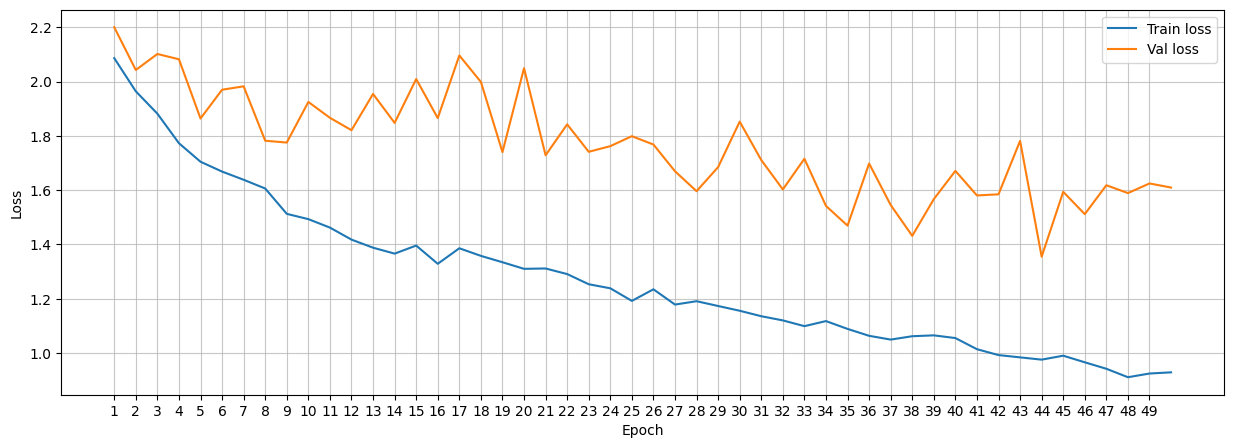

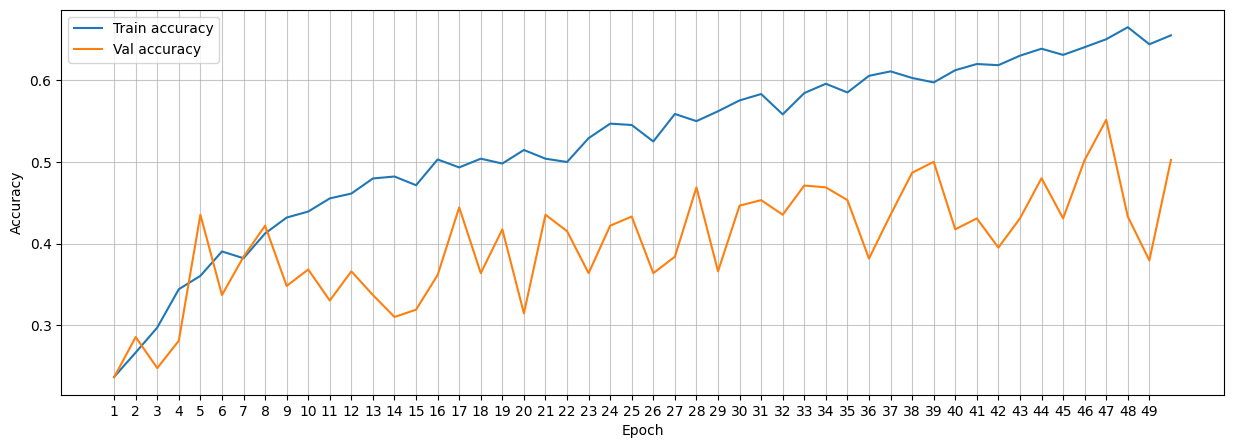

In [75]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # shape: [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


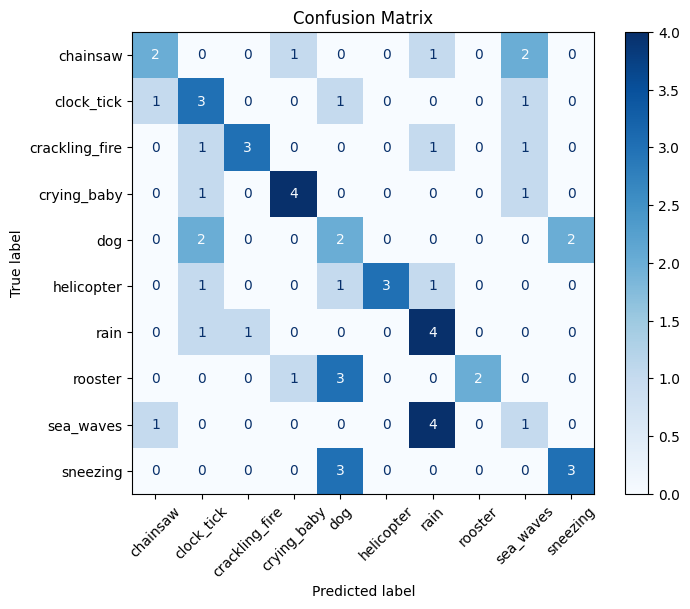

In [77]:
class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

evaluate_and_plot_confusion_matrix(snn_classifier, delta_test_dataloader, class_names)
